In [2]:
# imported libraries
import os
import email
import csv
import pandas as pd


In [3]:
# loading google drive
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')



Mounted at /content/drive


In [4]:
# spam and not spam directories containing EML files are loading
spam_dir = "/content/drive/MyDrive/emiproject/Spam"
not_spam_dir = "/content/drive/MyDrive/emiproject/Not_Spam"


I want to load 47 samples of spam emails files and 47 of non-spam emails. Out of them , a csv dataset is to be  created in which spam emails are labelled as 0 and non-spams are 1. Primarily there are two features in dataset, "email_text" and "subject" from EML files.

In [5]:
samples = [] # empty list of samples



In [78]:
# Defining a python function to extract subject and email body and appending it in the list of samples with labelling
def decode_email(file_path, max_chars=200):
    """
    Decode an email from a file with error handling and metadata extraction.

    Parameters:
    file_path (str): Path to the email file.
    max_chars (int): Maximum number of characters to read from the email body.

    Returns:
    (str, str, str): Email subject, email body (up to max_chars characters), and label.
    """
    try:
        with open(file_path, "r", encoding="latin-1") as file:  # Open in text mode with latin-1 encoding
            msg = email.message_from_file(file)
            subject = msg.get("Subject", "No Subject")
            email_text = msg.get_payload(decode=True).decode("utf-8", errors="ignore")[:max_chars]
            return subject, email_text
    except Exception as e:
        return  "Error_Sub","Error"



spam_dir = "/content/drive/MyDrive/emiproject/Spam"
not_spam_dir = "/content/drive/MyDrive/emiproject/Not_Spam"

# Collect 40 spam samples
for filename in os.listdir(spam_dir)[:47]:
    subject, email_text = decode_email(os.path.join(spam_dir, filename))
    label = 0
    samples.append((subject, email_text, label))

# Collect 40 not spam samples
for filename in os.listdir(not_spam_dir)[:47]:
    subject, email_text = decode_email(os.path.join(not_spam_dir, filename))
    label = 1
    samples.append((subject, email_text, label))




In [79]:
# Creating CSV dataset
with open("email_dataset.csv", "w", newline="") as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(["subject", "text", "label"])
    for sample in samples:
        writer.writerow(sample)

In [80]:
# Let's create a dataframe out of it
email_df = pd.read_csv("/content/email_dataset.csv")

In [82]:
# Counting the rows with label '1'
count_label_1 = (email_df['label'] == 1).sum()

# Counting the rows with label '0'
count_label_0 = (email_df['label'] == 0).sum()

print("Count of rows with label '1':", count_label_1)
print("Count of rows with label '0':", count_label_0)

Count of rows with label '1': 94
Count of rows with label '0': 94


In [83]:
email_df.head(5)

,subject,text,label
0,=?UTF-8?Q?=F0=9F=8C=B3=E2=9C=A8=20Navrati=20Tr...,"<!DOCTYPE html><html xmlns:v=""urn:schemas-micr...",0
1,Error_Sub,Error,0
2,Error_Sub,Error,0
3,Error_Sub,Error,0
4,Error_Sub,Error,0


In [86]:
import pandas as pd
import re

# Drop rows with the subject "Error_Sub"
tr_df = email_df[email_df['subject'] != 'Error_Sub'] # Cleaning the dataframe by removing rows containing "Error_Sub"



In [87]:
tr_df.head(5)

,subject,text,label
0,=?UTF-8?Q?=F0=9F=8C=B3=E2=9C=A8=20Navrati=20Tr...,"<!DOCTYPE html><html xmlns:v=""urn:schemas-micr...",0
5,Black Friday is only 5 weeks away. Are you ready?,"<!DOCTYPE html>\n<html xmlns:v=""urn:schemas-mi...",0
9,Aluminum-free 72 hr odor control?,<!DOCTYPE html>\n<html>\n <head>\n <title>...,0
10,=?utf-8?B?Sm9pbiB1cyBmb3Igb3VyIE1hcmtldCBJbnNp...,<html><!DOCTYPE HTML>\r\n\r\n \r\n\r\n ...,0
13,"Hey, you can make a big tech career happen!","<!doctype html><html xmlns:v=""urn:schemas-micr...",0


Now it's time to see a little bit analysis. I want to know the words which are present in text of non_spam email_bodies but not present in spam email_bodies. Let's check the difference for "subject" and "text" column of our dataframe.
**Defining a python function which will extract the "taboo" words for our dataset and return a list of these.**

In [88]:
def make_wordiff_list(df,text_column):
  label_1_list = []
  label_0_list = []
  for index, row in df.iterrows(): # Initiating loop in rows of the dataframe
        text = row[text_column]
        label = row["label"]  # getting the value of label for each row
        row_words = text.split(' ')
        # Separating label 1 list of words and label 0 list of words in two lists
        if label == 1:
          for rw in row_words:
            label_1_list.append(str(rw).lower())
        elif label == 0:
          for rw in row_words:
            label_0_list.append(str(rw).lower())

  diff_1_0 = [] # Initializing empty list of different words which are present in label_1_list and absent in label_0_list

  for x in label_1_list:
    if x not in label_0_list:
      diff_1_0.append(x)

  return diff_1_0




In [89]:
# For subject column, getting the difference word list
sub_diff = make_wordiff_list(tr_df,"subject")

In [90]:
# For subject column, getting the difference word list
text_diff = make_wordiff_list(tr_df,"text")

In [91]:
# Defining a python function to count occurence of word in a list
def count_word_occurrences(word, word_list):
    count = 0
    for item in word_list:
        if item == word:
            count += 1
    return count

Now I want to make a list of frequency of words for two columns in dataframe. The python function takes dataframe, column and unique word list . Then by this function, counts of frequencies of difference word list are stored in two separate lists named after two column-names.

In [92]:
def count_word_frequency(df, column, word_list):
    # Initialize a dictionary to store word frequencies
    sum_freq_df = []

    # Iterate through the rows of the specified column
    for index, row in df.iterrows():
        text = row[column]
        text = str(text)
        text = text.split(" ")
        sum_count = 0
        for word in word_list:
          word_count = count_word_occurrences(word,text)
          sum_count = sum_count + word_count
        sum_freq_df.append(sum_count)

    return sum_freq_df


In [96]:
sub_word_freq = count_word_frequency(tr_df,"subject",text_diff)


In [59]:
text_word_freq = count_word_frequency(tr_df,"text",text_diff)
print(text_word_freq)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 4, 2, 5, 6, 2, 3, 6, 2, 3, 2]


In [61]:
print(sub_word_freq)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 2, 6, 1, 9, 21, 4, 6, 0, 6, 19]


In [41]:
sub_word_freq

[5,
 7,
 10,
 12,
 12,
 13,
 15,
 19,
 21,
 24,
 25,
 28,
 31,
 32,
 33,
 44,
 56,
 68,
 85,
 93,
 116,
 128,
 141,
 151,
 161,
 185]

In [97]:
import matplotlib.pyplot as plt

# Your data: text_word_freq and sub_word_freq
text_word_freq = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 4, 2, 5, 6, 2, 3, 6, 2, 3, 2]
sub_word_freq = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 2, 6, 1, 9, 21, 4, 6, 0, 6, 19]

# Determine spam emails based on your hypothesis boundary
spam_emails = [i for i, freq in enumerate(text_word_freq) if freq == 0]
normal_emails = [i for i in range(len(text_word_freq)) if i not in spam_emails]



Now I am going to plot a scatter plot where:
*   x = value of text_word_freq
*   y = value of sub_word_freq + value of index

So each point represents a email which is defined with these two features. There are 26 data points in our dataset.

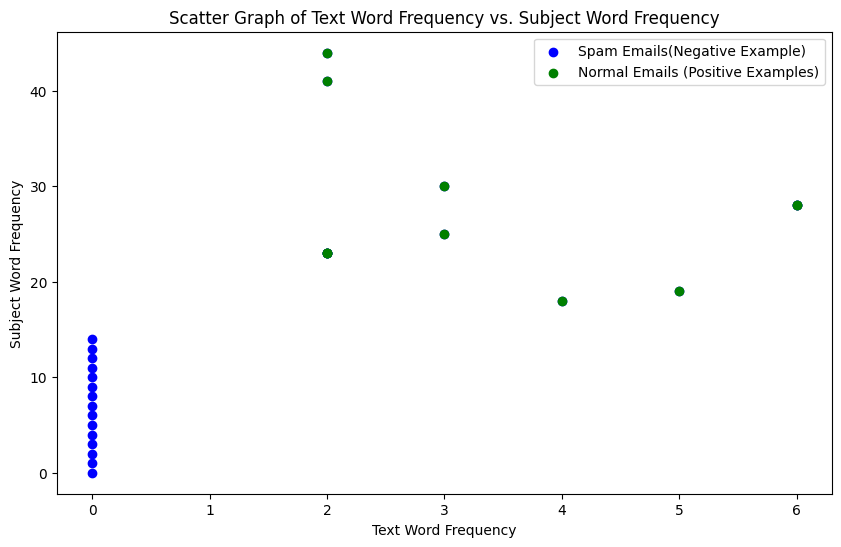

In [106]:
# Plotting the scatter graph
plt.figure(figsize=(10, 6))
plt.scatter(text_word_freq, [i + j for i, j in zip(range(len(text_word_freq)), sub_word_freq)], c='b', label='Spam Emails(Negative Example)')
plt.scatter([text_word_freq[i] for i in normal_emails], [i + sub_word_freq[i] for i in normal_emails], c='g', label='Normal Emails (Positive Examples)')
plt.xlabel('Text Word Frequency')
plt.ylabel('Subject Word Frequency')
plt.legend()
plt.title('Scatter Graph of Text Word Frequency vs. Subject Word Frequency')
plt.show()

Observing this scatter plot and data points , we are making a hypothesis to separate spam emails and normal emails. The two straight lines are taken:


*   x = 2
*   y = 18

These straight lines are to bind the rectangular regions. Let's visualize this.



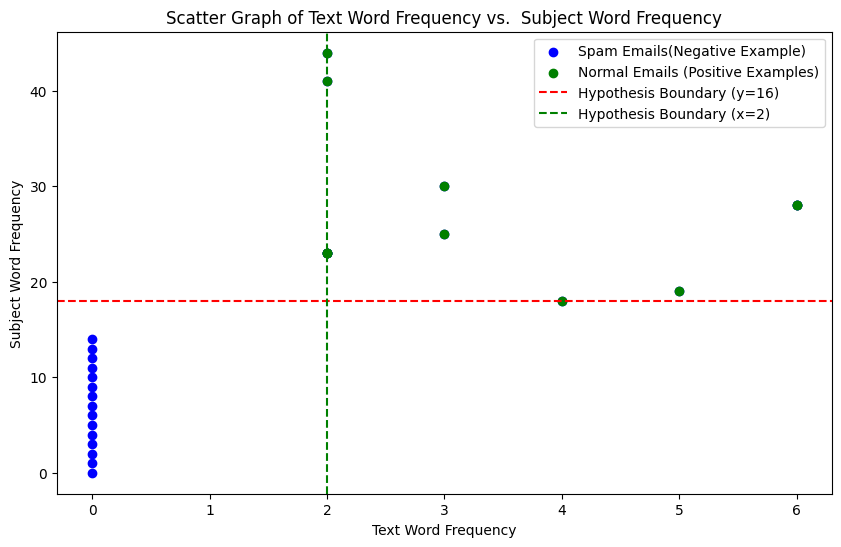

In [105]:
# Plotting the scatter graph
plt.figure(figsize=(10, 6))
plt.scatter(text_word_freq, [i + j for i, j in zip(range(len(text_word_freq)), sub_word_freq)], c='b', label='Spam Emails(Negative Example)')
plt.scatter([text_word_freq[i] for i in normal_emails], [i + sub_word_freq[i] for i in normal_emails], c='g', label='Normal Emails (Positive Examples)')
# Draw the decision boundary lines
plt.axhline(18, color='r', linestyle='--', label='Hypothesis Boundary (y=16)')
plt.axvline(2, color='g', linestyle='--', label='Hypothesis Boundary (x=2)')
plt.xlabel('Text Word Frequency')
plt.ylabel('Subject Word Frequency')
plt.legend()
plt.title('Scatter Graph of Text Word Frequency vs.  Subject Word Frequency')
plt.show()

So this hypothesis is successfull to separate the spam and normal email points . These regions are divided into two rectangular regions. Also this hypothesis shatters 4 positive data points . So the VC dimension of this hypothesis is 4.